In [25]:
# External dependencies
import numpy as np
import pandas as pd
import yfinance as yf

# Constants
TRADING_DAYS: int = 10
VOL_TARGET: float = 0.20
TRADING_HOURS_PER_DAY: int = 7
TRADING_30_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 2
TRADING_5_MIN_PER_DAY: int = TRADING_HOURS_PER_DAY * 12

Load Data

In [17]:
daily = yf.download(tickers="SPY", interval="1d")["Close"].pct_change()
hourly = yf.download(tickers="SPY", start="2023-01-01", interval="1h")["Close"].pct_change()
min_30 = yf.download(tickers="SPY", start="2024-10-15", interval="30m")["Close"].pct_change()
min_5 = yf.download(tickers="SPY", start="2024-10-15", interval="5m")["Close"].pct_change()

returns = pd.concat(
    [
        daily,
        hourly,
        min_30,
        min_5
    ],
    axis=1
)
returns.columns = ["1d", "1h", "30m", "5m"]
returns

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,1d,1h,30m,5m
1993-01-29 00:00:00+00:00,NaN,NaN,NaN,NaN
1993-02-01 00:00:00+00:00,0.007112,NaN,NaN,NaN
1993-02-02 00:00:00+00:00,0.002119,NaN,NaN,NaN
1993-02-03 00:00:00+00:00,0.010571,NaN,NaN,NaN
1993-02-04 00:00:00+00:00,0.004184,NaN,NaN,NaN
...,...,...,...,...
2024-12-13 20:35:00+00:00,NaN,NaN,NaN,0.000215
2024-12-13 20:40:00+00:00,NaN,NaN,NaN,-0.000463
2024-12-13 20:45:00+00:00,NaN,NaN,NaN,0.000579
2024-12-13 20:50:00+00:00,NaN,NaN,NaN,-0.000876


Build Exponentially Weighted Risk Model

In [22]:
risk_model = pd.concat(
    [
        (returns["1d"].dropna().ewm(halflife=TRADING_DAYS / 2).std().dropna() * np.sqrt(252)).tail(20),
        (returns["1h"].dropna().ewm(halflife=TRADING_DAYS * TRADING_HOURS_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_HOURS_PER_DAY * 252)).tail(20 * TRADING_HOURS_PER_DAY),
        (returns["30m"].dropna().ewm(halflife=TRADING_DAYS * TRADING_30_MIN_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_30_MIN_PER_DAY * 252)).tail(20 * TRADING_30_MIN_PER_DAY),
        (returns["5m"].dropna().ewm(halflife=TRADING_DAYS * TRADING_5_MIN_PER_DAY / 2).std().dropna() * np.sqrt(TRADING_5_MIN_PER_DAY * 252)).tail(20 * TRADING_5_MIN_PER_DAY)
    ],
    axis=1
).ffill()
risk_model.columns = ["1d", "1h", "30m", "5m"]
risk_model["mean"] = risk_model.mean(axis=1)
risk_model["mean"].iloc[-1].round(4)

0.0804

Plot Ex Ante Risk

<Axes: title={'center': 'Ex Ante Volatility'}>

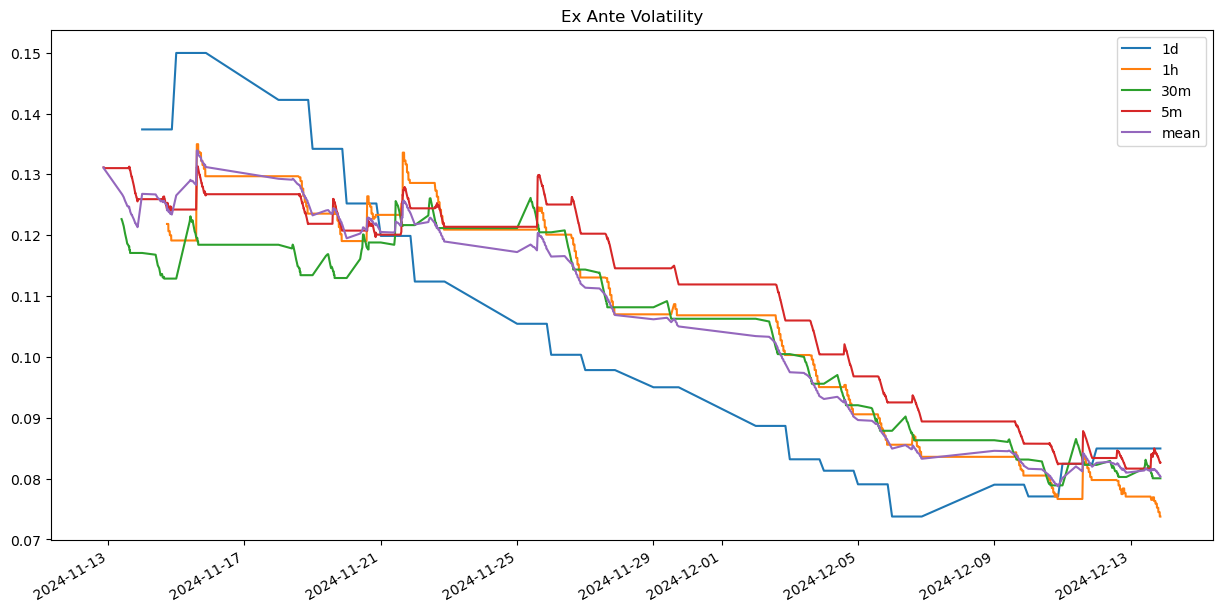

In [23]:
risk_model.plot(title="Ex Ante Volatility", figsize=(15, 7.5))

In [26]:
leverage_target = VOL_TARGET / risk_model["mean"].iloc[-1].round(4)
leverage_target

2.4875621890547266

In [53]:
ev = sum(np.arange(2, 15) / 13)
ev

7.999999999999999

In [54]:
var = sum(np.arange(2, 15) ** 2 / 13) - ev ** 2
var

14.000000000000014

In [55]:
std = np.sqrt(var)
std

3.741657386773943

In [56]:
3 * ev

23.999999999999996

In [ ]:
np.sqrt(3) * std

6.480740698407863

In [64]:
ev * 3 - np.sqrt(3) * std * 2, ev * 3 - np.sqrt(3) * std, ev * 3, ev * 3 + np.sqrt(3) * std, ev * 3 + np.sqrt(3) * std * 2

(11.03851860318427,
 17.519259301592133,
 23.999999999999996,
 30.48074069840786,
 36.96148139681572)

In [65]:
1 - .84

0.16000000000000003

In [67]:
0.84 - 0.16 / ((24 - 17) / 17)

0.45142857142857135

In [45]:
29-13


16

In [46]:
16*20

320

In [68]:
1 - 16 / 94

0.8297872340425532

In [69]:
26-19

7

In [70]:
7 * 15

105

In [72]:
0.84 - 0.16 / (7 / 17)

0.45142857142857135

In [82]:
0.6-.4/(4 / 14)

-0.8000000000000002

In [83]:
32-19

13

In [91]:
35*14

490

In [92]:
.84-4*.16

0.19999999999999996